In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import folium


sites_file = "Data-partie-1/Sites.csv"
onshore_file = "Data-partie-1/Rendements_onshore.csv"
offshore_file = "Data-partie-1/Rendements_offshore.csv"

P = 500000
k = 0.17

In [2]:
df = pd.read_csv(sites_file, skiprows=1, header=None)

data = df.values

onshore_capacity = np.array([i[7] for i in data if i[5] == "Non"], dtype=np.float64)
offshore_capacity = np.array([i[7] for i in data if i[5] == "Oui"], dtype=np.float64)
n_onshore = len(onshore_capacity)
n_offshore = len(offshore_capacity)
n = n_onshore+n_offshore

df_onshore = pd.read_csv(onshore_file, header=None)
df_offshore = pd.read_csv(offshore_file, header=None)

onshore_data = df_onshore.values
offshore_data = df_offshore.values

onshore_indices = np.where(data[:, 5] == "Non")[0]
offshore_indices = np.where(data[:, 5] == "Oui")[0]

onshore_yield = onshore_data[onshore_indices].astype(np.float64)
offshore_yield = offshore_data[offshore_indices].astype(np.float64)

In [3]:
h = np.shape(onshore_yield)[1]
c = np.concatenate((onshore_capacity, offshore_capacity))
R = np.concatenate((onshore_yield, offshore_yield))
A = c[:, np.newaxis] * R

In [4]:
# print(c)
id_matrix = np.identity(n)
i_matrix_part1 = np.concatenate((np.concatenate((id_matrix, -id_matrix)), np.zeros((2 * n, 1))), axis=1)
i_matrix_part2 = np.concatenate((-np.transpose(A), np.ones((h, 1))), axis=1)
i_matrix = np.concatenate((i_matrix_part1, i_matrix_part2))
i_vector = np.concatenate((np.ones(n), np.zeros(n + h)))

e_matrix_row1 = np.concatenate((c, np.zeros(1)))
e_matrix_row2 = np.concatenate((np.zeros(n_onshore), offshore_capacity, np.zeros(1)))
e_matrix = np.array([e_matrix_row1, e_matrix_row2])
e_vector = np.array([P, k * P])

obj_func_coeffs = np.concatenate((np.zeros(n), np.array([-1])))

solution = linprog(obj_func_coeffs, i_matrix, i_vector, e_matrix, e_vector)

x = solution.x
x = x[0:n]
y = -solution.fun

In [5]:
E = np.zeros(h)
Yield = np.zeros(h)

for j in range(h):
    E[j] = np.dot(x, A[:, j])
    Yield[j] = np.dot(x, R[:, j]) / np.sum(x)

E_total = np.sum(E)
Yield_avg = np.mean(Yield)

In [6]:
latitude = [i[1] for i in data]
longitude = [i[2] for i in data]
country = [i[3] for i in data]
color = [i[4] for i in data]

latitude = pd.to_numeric(latitude, errors='coerce')
longitude = pd.to_numeric(longitude, errors='coerce')

valid_indices = np.where(~np.isnan(latitude) & ~np.isnan(longitude))
latitude = latitude[valid_indices]
longitude = longitude[valid_indices]
color = np.array(color)[valid_indices]

In [7]:
m = folium.Map(location=[np.median(latitude), np.median(longitude)], zoom_start=3)

print(x)

size = 4
# Add points to the map
for idx in range(len(latitude)):
    # Use size and color variables from your original code
    if x[idx] == 0:
        continue
    folium.CircleMarker(
        location=[latitude[idx], longitude[idx]],
        radius=size * x[idx],  # Use size if perSize is True, else use 1
        color=color[idx],
        fill=True,
        fill_color=color[idx],
        fill_opacity=1.0  # Set fill_opacity to 1.0 for solid fill
    ).add_to(m)

m.save(outfile="map.html")
display(m)

[1.         1.         1.         0.         1.         0.
 0.19534158 1.         1.         1.         0.         0.
 0.         1.         1.         1.         1.         0.
 0.         0.         1.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         1.         0.         0.         0.         1.
 1.         1.         0.         0.         0.         0.
 0.11680891 1.         0.         0.         0.         0.
 1.         1.         1.         1.         1.         1.
 1.         0.11498911 1.         1.         0.         1.
 1.         1.         1.         1.         0.         0.
 0.         0.         1.         1.         1.         1.
 1.         0.         0.         1.         0.82680332 0.
 0.         0.         0.         0.         0.         

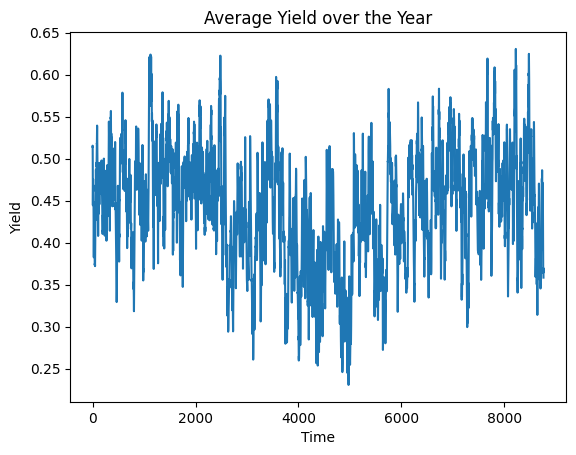

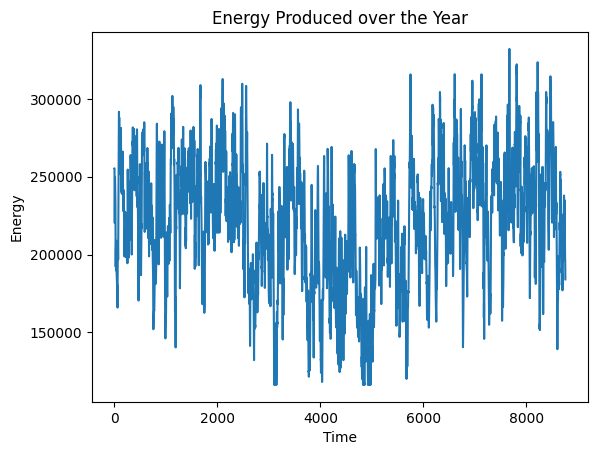

In [8]:
plt.plot(Yield)
plt.xlabel('Time')
plt.ylabel('Yield')
plt.title('Average Yield over the Year')
plt.savefig('average_yield.png')
plt.show()


plt.plot(E)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Produced over the Year')
plt.savefig('energy_produced.png')
plt.show()

In [10]:
windmills_used = sum(x)

print(f"Minimum energy produced in one hour: {y}")
print(f"Average annual yield: {Yield_avg*100}%")
print(f"Energy produced in one year: {E_total}")
print(f"Amount of windmills used: {windmills_used}")

Minimum energy produced in one hour: 116226.59223094779
Average annual yield: 44.166513759219114%
Energy produced in one year: 1945870075.4489331
Amount of windmills used: 266.95540938960335
